Data before cleaning             Close/Last    Volume      Open      High       Low
Date                                                          
2020-05-08    $310.13   33511990  $305.64   $310.35   $304.29 
2020-05-07    $303.74   28803760  $303.22   $305.17   $301.97 
2020-05-06    $300.63   35583440  $300.46   $303.24   $298.87 
2020-05-05    $297.56   36937800  $295.06      $301   $294.46 
2020-05-04    $293.16   33391990  $289.17   $293.69   $286.32 
...                ...       ...       ...       ...       ...
2015-05-15    $128.77   38128470  $129.07   $129.49   $128.21 
2015-05-14    $128.95   45123920  $127.41   $128.95   $127.16 
2015-05-13    $126.01   34611600  $126.15   $127.19   $125.87 
2015-05-12    $125.87   48073450  $125.60   $126.88   $124.82 
2015-05-11    $126.32   41920740  $127.39   $127.56   $125.63 

[1259 rows x 5 columns]
Data after cleaning             Close/Last
Date                  
2015-05-11     126.32 
2015-05-12     125.87 
2015-05-13     126.01 


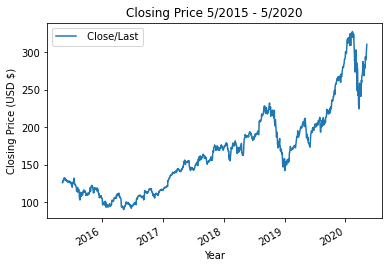

In [11]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import io
from google.colab import files
from matplotlib import pyplot
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from sklearn import preprocessing
#upload csv below
#uploaded = files.upload()

series = pd.read_csv('aapl5.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=pd.to_datetime)
print("Data before cleaning",series)

series = series[::-1]
seriesdf = pd.DataFrame(series)
seriesdf.iloc[:,0] = seriesdf.iloc[:,0].str.replace('$','')
seriesdf.iloc[:,0] = seriesdf.iloc[:,0].str.replace(',','')

seriesdf = seriesdf.drop(seriesdf.columns[4],axis = 1)
seriesdf = seriesdf.drop(seriesdf.columns[3],axis = 1)
seriesdf = seriesdf.drop(seriesdf.columns[2],axis = 1)
seriesdf = seriesdf.drop(seriesdf.columns[1],axis = 1)

print("Data after cleaning", seriesdf)
seriesdf.iloc[:,0] = pd.to_numeric(seriesdf.iloc[:,0])
seriesdf.plot()
pyplot.title("Closing Price 5/2015 - 5/2020")

pyplot.xlabel("Year")
pyplot.ylabel("Closing Price (USD $)")
pyplot.show()




In [0]:
def timeseries_to_supervised(df, lag=1):
	dfdf = pd.DataFrame(df)
	columns = [dfdf.shift(i) for i in range(1, lag+1)]
	columns.append(dfdf)
	dfdf = pd.concat(columns, axis=1)
	dfdf.fillna(0, inplace=True)
	return dfdf
def my_diff(data,interval = 1):
  diff = []
  for i in range(interval, len(data.iloc[:,0])):
    value = data.iloc[i,0] - (data.iloc[i - interval,0])
    diff.append(value)
  return diff

In [0]:

X = seriesdf.values
X = X.reshape(len(X),1)
scaler = preprocessing.MinMaxScaler(feature_range=(-1,1))
scaler = scaler.fit(X)
scaled_X = scaler.transform(X)
scaled_series = pd.Series(scaled_X[:,0])

inverted_X = scaler.inverse_transform(scaled_X)
inverted_series = pd.Series(inverted_X[:,0])

def scale_data(train, test):
	scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled


RMSE 5.29328775073654


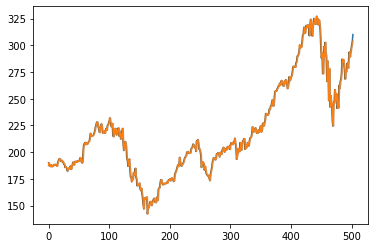

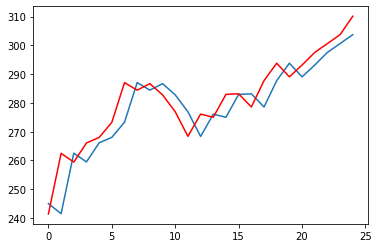

In [15]:
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from math import sqrt
from matplotlib import pyplot
import numpy


raw = seriesdf.values
diffval = my_diff(seriesdf)
supervised = timeseries_to_supervised(diffval)
supervisedval = supervised.values
train, test = supervisedval[0:-503],supervisedval[-503:]
scaler,train_scaled,test_scaled = scale(train,test)


def train_model(train, batch, epoch, input):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(input, batch_input_shape=(batch, X.shape[1], X.shape[2]), stateful=True, return_sequences=True))
	model.add(Dense(1,activation='tanh'))
	model.add(Dropout(.5))
	model.add(LSTM(30, batch_input_shape=(batch, X.shape[1], X.shape[2]), stateful=True, return_sequences=True))
	model.add(Dense(1, activation='tanh'))
	model.add(Dropout(.3))
	model.add(LSTM(3, batch_input_shape=(batch,X.shape[1],X.shape[2]),stateful=True))
	model.add(Dropout(.2))
	model.add(Dense(1, activation='tanh'))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(epoch):
		model.fit(X, y, epochs=1, batch_size=batch, verbose=0, shuffle=False)
		model.reset_states()
	return model


def test_model(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]


def invert_my_diff(history, yhat, interval=1):
	return yhat + history[-interval]
lstm_model = fit_lstm(train_scaled, 1, 2, 100)
print(lstm_model)

train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

predictions = list()
for i in range(len(test_scaled)):
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 2, X)
	yhat = invert_scale(scaler, X, yhat)
	yhat = inverse_difference(raw, yhat, len(test_scaled)+1-i)
	predictions.append(yhat)
	expected = raw[len(train) + i + 1]
	#print('Predicted=%f, Expected=%f' % (yhat, expected))

#error
rmse = sqrt(mean_squared_error(raw[-503:], predictions))
print('RMSE',rmse)
# line plot of predicted and expected
pyplot.plot(raw[-503:])
pyplot.plot(predictions)
pyplot.show()


#zoomed in view of predicted and expected
pyplot.plot(predictions[-25:])
pyplot.plot(raw[-25:], color = 'red')
pyplot.show()